In [66]:
from os.path import join as pjoin

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.io import read_image

from sklearn.model_selection import train_test_split

In [75]:
classes = np.array([
    'abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'bart_simpson',
       'charles_montgomery_burns', 'chief_wiggum', 'comic_book_guy',
       'edna_krabappel', 'homer_simpson', 'kent_brockman',
       'krusty_the_clown', 'lisa_simpson', 'marge_simpson',
       'milhouse_van_houten', 'moe_szyslak', 'ned_flanders',
       'nelson_muntz', 'principal_skinner', 'sideshow_bob'
    ])
num_classes = classes.shape[0]

image_resize_train = (64, 64)

epochs = 3

batch_size = 256

In [68]:


transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(image_resize_train),
    torchvision.transforms.CenterCrop(image_resize_train),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        [0.5],
        [0.5]
    )
])

class LabelTransformer():
    def __init__(self, initial_list = classes):
        self.initial_list = initial_list
    
    def __call__(self, val):
        if type(val) == str:
            return self.toInt(val)
        elif type(val) == int or type(val) == np.int64:
            return self.toStr(val)
        return None

    def toInt(self, label : str) -> int:
        return np.where(self.initial_list == label)[0][0]
    
    def toStr(self, ind : int) -> str:
        return self.initial_list[ind]
    
class SimpsonsDataset(Dataset):
    def __init__(self, annotations, img_dir, transform = None, label_transform = None):
        self.annotations = annotations
        self.img_dir = img_dir
        self.transform = transform
        self.label_transform = label_transform
    
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = pjoin(self.img_dir, self.annotations.iloc[index, 0][2:])
        image = read_image(img_path)
        label = self.annotations.iloc[index, -1]
        border = np.array(list(self.annotations.iloc[index, 1:-1]))
        if self.transform:
            image = self.transform(image)
        if self.label_transform:
            label = self.label_transform(label)
        return image, label, border

In [69]:
annotations = pd.read_csv('dataset/annotation.txt', header=None)

train_files, valid_files = train_test_split(annotations, test_size=0.3)

train_dataset = SimpsonsDataset(
    train_files,
    img_dir='dataset',
    transform=transform,
    label_transform=LabelTransformer()
 )

valid_dataset = SimpsonsDataset(
    valid_files,
    img_dir='dataset',
    transform=transform,
    label_transform=LabelTransformer()
 )

<Figure size 640x480 with 0 Axes>

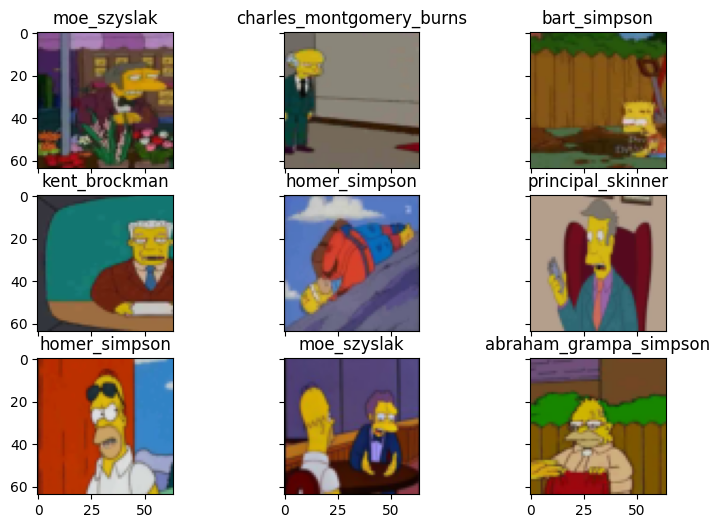

In [70]:
import matplotlib.pyplot as plt

figure = plt.figure()

def imshow(img, title, plt_ax=plt):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.5])
    std = np.array([0.5])
    img = std * img + mean
    plt_ax.imshow(img)
    plt_ax.set_title(title)
    plt_ax.grid(False)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9, 6), sharey=True, sharex=True)

for fig_x in ax.flatten():
    character_index = int(np.random.uniform(0, len(train_dataset)))
    img, label, _ = train_dataset[character_index]
    label = LabelTransformer()(label)
    imshow(img.data.cpu(), title=label, plt_ax=fig_x)

In [71]:
model = torchvision.models.resnet152(weights=torchvision.models.ResNet152_Weights.DEFAULT)
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, num_classes)

model.cuda()


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD( 
    params=model.parameters(),
    lr=0.01,
    momentum=0.9,
)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [76]:

def train_step():
    model.train()
    running_loss = 0.
    for images, labels, borders in train_dataloader:
        images = images.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
    with torch.no_grad():
        train_loss = running_loss / len(train_dataloader)
    return train_loss.item()

def valid_step():
    model.eval()
    correct_total = 0
    running_loss = 0
    with torch.no_grad():
        for images, labels, border in valid_dataloader:
            images = images.cuda()
            labels = labels.cuda()

            output = model(images)
            prediction = output.max(dim = 1, keepdim=True)[1]
            correct_total += prediction.eq(labels.view_as(prediction)).sum()
            loss = criterion(output, labels)
            running_loss = loss
        valid_loss = running_loss / len(valid_dataloader)
        accuracy = correct_total / len(valid_dataloader.dataset)
        return valid_loss.item(), accuracy.item()

train_losses = []
valid_losses = []
valid_accs = []

from tqdm import tqdm

for _ in (pbar := tqdm(range(epochs))):
    train_loss = train_step()
    valid_loss, valid_acc = valid_step()
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    pbar.set_description(f'Avg. train/valid loss: {train_loss:.4f}/{valid_loss:.4f}')

Avg. train/valid loss: 0.0138/0.0178: 100%|██████████| 3/3 [03:56<00:00, 78.79s/it] 


Text(0, 0.5, 'Accuracy')

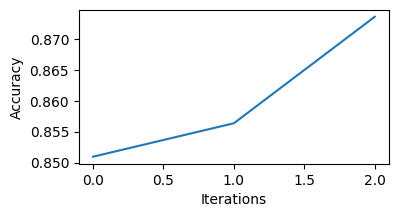

In [80]:
fig = plt.figure(figsize=(4, 2))

plt.plot(valid_accs)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')